In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [3]:
PLOTS = '../data/processed/blm_usfs_wadnr_plot_footprints.shp'
gdf = gpd.read_file(PLOTS)
gdf['agency'] = gdf['source'].apply(lambda x: x.split('-')[0].replace('WA', 'WADNR'))
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5089 entries, 0 to 5088
Data columns (total 11 columns):
comments     496 non-null object
lat          5089 non-null float64
lon          5089 non-null float64
meas_date    3866 non-null object
orig_id      5089 non-null object
plot_id      3866 non-null object
source       5089 non-null object
meas_yr      5089 non-null int64
uuid         5089 non-null object
geometry     5089 non-null object
agency       5089 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 437.4+ KB


In [37]:
ECOREGIONS = '../data/raw/epa/us_eco_l3_state_boundaries.shp'
ecoreg = gpd.read_file(ECOREGIONS)
ecoreg = ecoreg.loc[ecoreg.STATE_NAME.isin(['Washington', 'Oregon'])]
ecoreg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82 entries, 15 to 1630
Data columns (total 14 columns):
US_L3CODE     82 non-null object
US_L3NAME     82 non-null object
NA_L3CODE     82 non-null object
NA_L3NAME     82 non-null object
NA_L2CODE     82 non-null object
NA_L2NAME     82 non-null object
NA_L1CODE     82 non-null object
NA_L1NAME     82 non-null object
STATE_NAME    82 non-null object
EPA_REGION    82 non-null int64
L3_KEY        82 non-null object
L2_KEY        82 non-null object
L1_KEY        82 non-null object
geometry      82 non-null object
dtypes: int64(1), object(13)
memory usage: 9.6+ KB


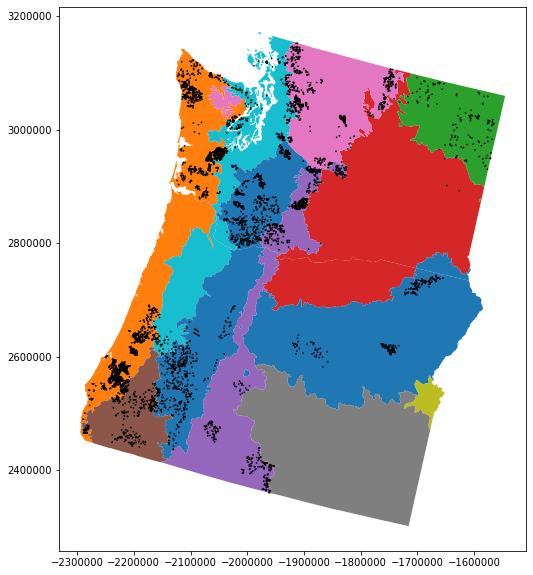

In [60]:
fig, axs = plt.subplots(1, figsize=(10,10))
ecoreg.plot(ax=axs, column='NA_L3NAME')
gdf.to_crs(ecoreg.crs).buffer(1500).plot(ax=axs, color='k')
plt.show()

In [4]:
DATA = '../data/processed/training_data_annual.csv'
df = pd.read_csv(DATA)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4528 entries, 0 to 4727
Columns: 150 entries, uuid to year_diff
dtypes: float64(56), int64(92), object(2)
memory usage: 5.2+ MB


In [5]:
# a dataframe with the plot ids and agency sources
splits = pd.DataFrame(pd.unique(df['uuid']), 
                      columns=['uuid']).merge(gdf[['uuid', 'agency']], on='uuid').set_index('uuid')

# randomly assign each plot-id to train(0) or test(1) sets
np.random.seed(127)
splits['train0_test1'] = np.random.choice(2,
                                          size=len(splits),
                                          p=[0.8,0.2])

In [6]:
# confirm how the split falls out for the plots from each agency
(splits.reset_index().groupby(by=['agency', 'train0_test1'])['uuid'].count() / \
    splits.reset_index().groupby(by=['agency'])['uuid'].count()).round(2)

agency  train0_test1
BLM     0               0.80
        1               0.20
USFS    0               0.81
        1               0.19
WADNR   0               0.80
        1               0.20
Name: uuid, dtype: float64

In [7]:
# add set assignments to the dataframe
df['agency'] = splits.loc[df['uuid']]['agency'].values
df['train0_test1'] = splits.loc[df['uuid']]['train0_test1'].values
# convert agency into a one-hot encoded set of variables
df = pd.get_dummies(df, prefix='agency', columns=['agency'])

In [8]:
# confirm how the fold assignments fall out for the plots from each agency
train_plots = df.loc[df['train0_test1'] == 0]
test_plots = df.loc[df['train0_test1'] == 1]

In [9]:
len(train_plots), len(test_plots)

(3634, 894)

In [10]:
CLIM_COLS = ['mat', 'mwmt', 'mcmt', 'td', 'map', 'msp', 'ahm', 'shm', 
             'dd_0', 'dd5', 'dd_18', 'dd18', 'nffd', 'bffp', 'effp', 
             'ffp', 'pas', 'emt', 'ext', 'eref', 'cmd', 'rh']
LIDAR_COLS = ['strat0_return-proportion',
       'strat1_return-proportion', 'strat2_return-proportion',
       'strat3_return-proportion', 'strat4_return-proportion',
       'strat5_return-proportion', 'strat0_intensity-median',
       'strat1_intensity-median', 'strat2_intensity-median',
       'strat3_intensity-median', 'strat4_intensity-median',
       'strat5_intensity-median', 'height_05-percentile',
       'height_25-percentile', 'height_50-percentile', 'height_75-percentile',
       'height_95_percentile', 'height_max', 'cover', 'potential_volume',
       'stddev_height', 'surface_area_ratio', 'surface_volume',
       'surface_volume_ratio', 'aspect', 'elevation', 'overall_curvature',
       'plan_curvature', 'profile_curvature', 'slope', 'solar_radiation_index']

SOIL_COLS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']

LANDSAT_COLS = ['green', 'blue', 'red', 'nir', 'endvi', 'ndvi', 'savi',
       'swir1', 'swir2', 'wetness', 'greenness', 'brightness']

In [11]:
AGENCY_COLS = ['agency_BLM', 'agency_USFS', 'agency_WADNR']
X_COLS = ['year_diff', 'distance_to_water_m'] + LIDAR_COLS + AGENCY_COLS
Y_COLS = ['qmd']
x_train, x_test = train_plots[X_COLS].reset_index(drop=True), test_plots[X_COLS].reset_index(drop=True)
y_train, y_test = train_plots[Y_COLS].reset_index(drop=True), test_plots[Y_COLS].reset_index(drop=True)

usfs_train_idx, usfs_test_idx = x_train.loc[x_train.agency_USFS == 1].index, x_test.loc[x_test.agency_USFS == 1].index
x_train_usfs, x_test_usfs = x_train.loc[usfs_train_idx].drop(AGENCY_COLS, axis=1), x_test.loc[usfs_test_idx].drop(AGENCY_COLS, axis=1)
y_train_usfs, y_test_usfs = y_train.loc[usfs_train_idx], y_test.loc[usfs_test_idx]

dnr_train_idx, dnr_test_idx = x_train.loc[x_train.agency_WADNR == 1].index, x_test.loc[x_test.agency_WADNR == 1].index
x_train_dnr, x_test_dnr = x_train.loc[dnr_train_idx].drop(AGENCY_COLS, axis=1), x_test.loc[dnr_test_idx].drop(AGENCY_COLS, axis=1)
y_train_dnr, y_test_dnr = y_train.loc[dnr_train_idx], y_test.loc[dnr_test_idx]

blm_train_idx, blm_test_idx = x_train.loc[x_train.agency_BLM == 1].index, x_test.loc[x_test.agency_BLM == 1].index
x_train_blm, x_test_blm = x_train.loc[blm_train_idx].drop(AGENCY_COLS, axis=1), x_test.loc[blm_test_idx].drop(AGENCY_COLS, axis=1)
y_train_blm, y_test_blm = y_train.loc[blm_train_idx], y_test.loc[blm_test_idx]

x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS].drop(AGENCY_COLS, axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
def calc_rmse(model):
    dnr_idx = x_test.loc[x_test.agency_WADNR == 1].index
    blm_idx = x_test.loc[x_test.agency_BLM == 1].index
    usfs_idx = x_test.loc[x_test.agency_USFS == 1].index
    
    y_pred = model.predict(x_scaler.transform(x_test.drop(AGENCY_COLS, axis=1)))
    # assumes log-transformed target
    dnr_pred = np.sqrt(mean_squared_error(y_test.loc[dnr_idx], np.exp(y_pred[dnr_idx])))
    blm_pred = np.sqrt(mean_squared_error(y_test.loc[blm_idx], np.exp(y_pred[blm_idx])))
    usfs_pred = np.sqrt(mean_squared_error(y_test.loc[usfs_idx], np.exp(y_pred[usfs_idx])))
    return dnr_pred, blm_pred, usfs_pred

In [14]:
gp = GaussianProcessRegressor()
gp.fit(x_scaler.transform(x_train_dnr), np.log(y_train_dnr.values.ravel()))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [15]:
# Set the parameters by cross-validation
knn_params = {'n_neighbors': [2, 5, 10, 15, 20, 50],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'manhattan']}


knn_gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')


knn_gs.fit(x_scaler.transform(x_train_dnr), np.log(y_train_dnr.values.ravel()))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  72 | elapsed:    2.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [2, 5, 10, 15, 20, 50],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [16]:
knn_gs.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')

In [17]:
calc_rmse(knn_gs.best_estimator_)

(4.527880841617514, 8.020355479996923, 6.297943249772285)

In [18]:
# Set the parameters by cross-validation
rf_params = {'n_estimators': [100, 500, 1000, 5000],
           'max_features': ['sqrt'],
           'max_depth': [10, 25, 50, 100],
           'min_samples_split': [2],
           'min_samples_leaf': [4],
           'bootstrap': [False]}


rf_gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

rf_gs.fit(x_scaler.transform(x_train_dnr), np.log(y_train_dnr.values.ravel()))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  48 | elapsed:    1.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  35 out of  48 | elapsed:   10.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   36.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth'

In [19]:
rf_gs.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [20]:
calc_rmse(rf_gs.best_estimator_)

(4.397863726115805, 8.499012978755847, 6.571001386080912)

In [21]:
# Set the parameters by cross-validation
gb_params = {'n_estimators': [100, 500, 1000, 5000],
             'learning_rate': [0.001, 0.01, 0.1],
             'n_estimators': [50, 100, 250, 500, 1000],
             'max_depth': [2, 3, 5, 10, 20]}


gb_gs = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=gb_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

gb_gs.fit(x_scaler.transform(x_train_dnr), np.log(y_train_dnr.values.ravel()))

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...e=None,
                      

In [22]:
gb_gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
calc_rmse(gb_gs.best_estimator_)

(4.581659947971072, 8.551418392110707, 6.560778505936737)

In [24]:
# Set the parameters by cross-validation
svm_params = {'kernel': ['linear', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto'],
              'C': [1,10,100,1000]
              }


svm_gs = GridSearchCV(estimator=SVR(), param_grid=svm_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

svm_gs.fit(x_scaler.transform(x_train_dnr), np.log(y_train_dnr.values.ravel()))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  72 | elapsed:    2.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [25]:
svm_gs.best_estimator_

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
calc_rmse(svm_gs.best_estimator_)

(4.354569272022099, 7.825180902376751, 6.222766010174308)

In [27]:
# Set the parameters by cross-validation
mlp_params = {'hidden_layer_sizes':[(100,100),(100,100,100)],
              'learning_rate_init': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
              'max_iter':[500], 
              'early_stopping':[True]
              }


mlp_gs = GridSearchCV(estimator=MLPRegressor(), param_grid=mlp_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

mlp_gs.fit(x_scaler.transform(x_train_dnr), np.log(y_train_dnr.values.ravel()))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  5.6min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=200,
                                    momentum=0.9, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_stat...
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'early_stopping': [True],
                         'hidden_layer_sizes': 

In [28]:
mlp_gs.best_estimator_

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(100, 100), learning_rate='constant',
             learning_rate_init=0.01, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [29]:
mlp_gs.best_estimator_.n_iter_

26

In [30]:
calc_rmse(mlp_gs.best_estimator_)

(4.854996174879899, 8.984048684383135, 1462.4756349528348)

In [31]:
MODELS = [svm_gs.best_estimator_, rf_gs.best_estimator_, knn_gs.best_estimator_, gb_gs.best_estimator_, mlp_gs.best_estimator_, gp]
names = [type(model).__name__ for model in MODELS]
scores = [calc_rmse(model)[0] for model in MODELS]

pd.Series(data=np.round(scores,2), index=names, name='RMSE').to_frame().sort_values('RMSE')

,RMSE
SVR,4.35
RandomForestRegressor,4.40
KNeighborsRegressor,4.53
GradientBoostingRegressor,4.58
MLPRegressor,4.85
GaussianProcessRegressor,11.91


In [33]:
importances = rf_gs.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_gs.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = x_train.drop(AGENCY_COLS, axis=1).columns[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

Feature ranking:
1. potential_volume (0.167516)
2. surface_volume (0.090364)
3. stddev_height (0.081227)
4. surface_area_ratio (0.072564)
5. height_95_percentile (0.062225)
6. height_75-percentile (0.059353)
7. height_max (0.038938)
8. strat5_return-proportion (0.036621)
9. strat2_return-proportion (0.034554)
10. height_50-percentile (0.031933)
11. strat4_return-proportion (0.027915)
12. strat3_return-proportion (0.025567)
13. strat5_intensity-median (0.017848)
14. strat1_return-proportion (0.017714)
15. strat2_intensity-median (0.017613)
16. cover (0.017332)
17. elevation (0.017049)
18. strat0_return-proportion (0.016198)
19. strat0_intensity-median (0.015812)
20. height_25-percentile (0.015732)
21. strat1_intensity-median (0.015265)
22. strat3_intensity-median (0.014704)
23. strat4_intensity-median (0.013729)
24. solar_radiation_index (0.013234)
25. year_diff (0.013150)
26. slope (0.011742)
27. aspect (0.011723)
28. distance_to_water_m (0.011595)
29. profile_curvature (0.009114)
30. 

IndexError: index 33 is out of bounds for axis 0 with size 33

In [ ]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
axs[0].scatter(y_test_dnr,
               np.exp(svm_gs.best_estimator_.predict(x_scaler.transform(x_test_dnr))),
               alpha=0.15, label='validation')

axs[1].scatter(y_train_dnr,
               np.exp(svm_gs.best_estimator_.predict(x_scaler.transform(x_train_dnr))),
               alpha=0.10, label='training')
for ax in axs:
    ax.set(aspect='equal')
    ax.set_xlim(0,45)
    ax.set_ylim(0,45)
    ax.plot(range(0,45), range(0,45), color='k')
    ax.set_ylabel('Predicted QMD')
    ax.set_xlabel('Observed QMD')
    
axs[0].set_title('Validation')
axs[1].set_title('Training')
plt.show()

In [ ]:
x_train[AGENCY_COLS].sum(axis=0)